# Create SVM Model

In this notebook, we will create the SVM models for the ICD9 multi-label problem

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()

Load in the data

In [2]:
data = pd.read_parquet('prepared-data.pq')
data.head()

,SUBJECT_ID,HADM_ID,TEXT,toks,ICD9_CODE
0,3,145834.0,sex m service medicine chief complaint admitt...,"[sex, m, service, medicine, chief, complaint, ...","[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
1,4,185777.0,sex f service chief complaint shortness of br...,"[sex, f, service, chief, complaint, shortness,...","[042, 1363, 7994, 2763, 7907, 5715, 04111, V090]"
2,6,107064.0,sex f service admission diagnosis end stage r...,"[sex, f, service, admission, diagnosis, end, s...","[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."
3,9,150750.0,sex m service neurology chief complaint weakn...,"[sex, m, service, neurology, chief, complaint,...","[431, 5070, 4280, 5849, 2765, 4019]"
4,10,184167.0,sex f service history of present illness baby...,"[sex, f, service, history, of, present, illnes...","[V3000, 7742, 76525, 76515, V290]"


1. Create the X, Y dataset

2. Convert codes to binary array

In [3]:
X = data['toks'].values
y_raw = data['ICD9_CODE'].astype(str)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['ICD9_CODE'].to_list())
mlb.classes_

array(['00845', '0088', '0380', ..., 'V8541', 'V8741', 'V8801'],
      dtype=object)

Display the number of codes, this should match from the pre-processing script. 

In [4]:
mlb.classes_.shape

(1292,)

Create the test/train split 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Create bag-of-words representation and preform TF-IDF.

Transform both the train and test

In [6]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df=0.001)
X_train = tfidf.fit_transform(X_train)
X_train

/home/ryan/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<47359x14116 sparse matrix of type '<class 'numpy.float64'>'
	with 26871534 stored elements in Compressed Sparse Row format>

In [7]:
X_test = tfidf.transform(X_test)

In [8]:
len(tfidf.vocabulary_)

14116

Create the model, for this model we will use SGDClassifier.

This classifier preforms the hinge loss which is what SVM uses, and additionally it uses SGD. We use SGD to speed up the model training process.

We also use One-vs-Rest strategy with the SVM model, where we create a new binary SVM for each class versus all other labels. 

In [9]:
clf = OneVsRestClassifier(SGDClassifier(loss='hinge', n_jobs=6, class_weight={0: 1, 1: 10}), n_jobs=6)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(class_weight={0: 1, 1: 10},
                                            n_jobs=6),
                    n_jobs=6)

We next use cross-validation to find class probabilties across 5 different folds. We will use the probabilities later to find the best threshold. 

In [10]:
cv = StratifiedKFold(n_splits=5)
calibrated_clf = MultiOutputClassifier(CalibratedClassifierCV(clf, cv=cv, n_jobs=6), n_jobs=6)
calibrated_clf.fit(X_train, y_train)

/home/ryan/miniconda3/envs/py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MultiOutputClassifier(estimator=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                                       estimator=OneVsRestClassifier(estimator=SGDClassifier(class_weight={0: 1,
                                                                                                                           1: 10},
                                                                                                             n_jobs=6),
                                                                                     n_jobs=6),
                                                       n_jobs=6),
                      n_jobs=6)

In [11]:
y_pred = calibrated_clf.predict_proba(X_test)
y_pred = np.dstack(y_pred)
y_pred = np.transpose(y_pred, (0, 2, 1))
y_pred.shape


(5263, 1292, 2)

In [12]:
y_pred_cls = (y_pred[:, :, 1] > 0.5) * 1

In [13]:
thresholds = np.arange(0, 1, 0.1)
data = []
for threshold in thresholds:
    y_pred_cls = (y_pred[:, :, 1] > threshold) * 1
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_cls, average='micro')
    data.append((threshold, precision, recall, fscore, support))

In [14]:
df = pd.DataFrame(data, columns=['threshold', 'precision', 'recall', 'fscore', 'support'])
df.head()

,threshold,precision,recall,fscore,support
0,0.0,0.008386,1.000000,0.016633,None
1,0.1,0.361772,0.590197,0.448579,None
2,0.2,0.481264,0.464866,0.472923,None
3,0.3,0.554488,0.385726,0.454961,None
4,0.4,0.608214,0.325647,0.424181,None


In [15]:
df.iloc[df['fscore'].argmax()]

threshold         0.2
precision    0.481264
recall       0.464866
fscore       0.472923
support          None
Name: 2, dtype: object

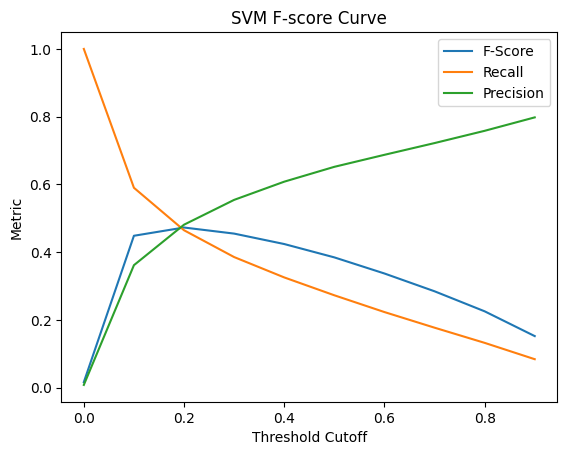

In [16]:
plt.figure()
plt.title("SVM F-score Curve")
plt.plot(df['threshold'], df['fscore'], label='F-Score')
plt.plot(df['threshold'], df['recall'], label='Recall')
plt.plot(df['threshold'], df['precision'], label='Precision')
plt.xlabel('Threshold Cutoff')
plt.ylabel('Metric')
plt.legend(loc='upper right')
# plt.text()
plt.savefig('svm-fscore.png')
plt.show()

In [17]:
df.to_csv('svm-scores.csv')

In [18]:
end = datetime.now()
total_time = end - start
total_time

datetime.timedelta(seconds=1672, microseconds=231593)